In [117]:
# Loading libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
import gc
import json
import ast
import time
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold, StratifiedKFold, KFold, train_test_split, GridSearchCV 
from sklearn.metrics import roc_auc_score
from sklearn import linear_model
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import eli5
from eli5.sklearn import PermutationImportance
import shap
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE
import statsmodels.api as sm

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train.shape

(250, 302)

In [10]:
# basic EDA

In [36]:
train.head(10)

,id,target,0,1,2,3,4,5,6,7,...,290,291,292,293,294,295,296,297,298,299
0,0,1.0,-0.098,2.165,0.681,-0.614,1.309,-0.455,-0.236,0.276,...,0.867,1.347,0.504,-0.649,0.672,-2.097,1.051,-0.414,1.038,-1.065
1,1,0.0,1.081,-0.973,-0.383,0.326,-0.428,0.317,1.172,0.352,...,-0.165,-1.695,-1.257,1.359,-0.808,-1.624,-0.458,-1.099,-0.936,0.973
2,2,1.0,-0.523,-0.089,-0.348,0.148,-0.022,0.404,-0.023,-0.172,...,0.013,0.263,-1.222,0.726,1.444,-1.165,-1.544,0.004,0.800,-1.211
3,3,1.0,0.067,-0.021,0.392,-1.637,-0.446,-0.725,-1.035,0.834,...,-0.404,0.640,-0.595,-0.966,0.900,0.467,-0.562,-0.254,-0.533,0.238
4,4,1.0,2.347,-0.831,0.511,-0.021,1.225,1.594,0.585,1.509,...,0.898,0.134,2.415,-0.996,-1.006,1.378,1.246,1.478,0.428,0.253
5,5,1.0,-0.641,-0.576,2.493,0.317,0.009,0.428,-1.887,2.412,...,-0.266,1.548,-0.523,0.923,0.021,-0.909,0.629,-2.386,0.265,0.549
6,6,1.0,-0.490,0.557,-0.881,0.831,0.247,2.316,1.268,1.679,...,1.131,0.808,-1.398,0.053,0.667,-1.175,2.330,2.104,0.007,-1.066
7,7,1.0,1.252,-1.370,-0.196,2.246,-0.617,-0.479,-0.629,1.642,...,-1.978,2.801,-1.643,-0.244,-0.864,-0.022,1.598,-0.693,-0.358,-0.084
8,8,1.0,1.410,-1.097,1.170,-0.091,-0.102,-0.835,-1.141,0.355,...,-1.546,-0.190,1.387,1.021,-0.912,0.094,-0.930,1.931,1.190,0.964
9,9,1.0,-1.811,0.566,-0.406,-0.490,-0.985,-0.303,1.068,-0.038,...,-0.705,1.045,-1.281,-1.727,-0.969,-1.367,0.109,1.416,1.472,1.458


In [13]:
# Определенной тематики нет, а значит пользуемся строго формальным описанием, фьючер импортанс и тп. 
# Посмотрим, на распределения, дисперсию, корреляции и далее :)

In [19]:
train.isnull().any()

id        False
target    False
0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
          ...  
270       False
271       False
272       False
273       False
274       False
275       False
276       False
277       False
278       False
279       False
280       False
281       False
282       False
283       False
284       False
285       False
286       False
287       False
288       False
289       False
290       False
291       False
292       False
293       False
294       False
295       False
296       False
297       False
298       False
299       False
Length: 302, dtype: bool

In [20]:
train.isnull().any().any()

False

In [29]:
X_train = train.drop(['id', 'target'], axis = 1)
y_train = train['target']

In [57]:
test.head()

,id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,250,0.500,-1.033,-1.595,0.309,-0.714,0.502,0.535,-0.129,-0.687,...,-0.088,-2.628,-0.845,2.078,-0.277,2.132,0.609,-0.104,0.312,0.979
1,251,0.776,0.914,-0.494,1.347,-0.867,0.480,0.578,-0.313,0.203,...,-0.683,-0.066,0.025,0.606,-0.353,-1.133,-3.138,0.281,-0.625,-0.761
2,252,1.750,0.509,-0.057,0.835,-0.476,1.428,-0.701,-2.009,-1.378,...,-0.094,0.351,-0.607,-0.737,-0.031,0.701,0.976,0.135,-1.327,2.463
3,253,-0.556,-1.855,-0.682,0.578,1.592,0.512,-1.419,0.722,0.511,...,-0.336,-0.787,0.255,-0.031,-0.836,0.916,2.411,1.053,-1.601,-1.529
4,254,0.754,-0.245,1.173,-1.623,0.009,0.370,0.781,-1.763,-1.432,...,2.184,-1.090,0.216,1.186,-0.143,0.322,-0.068,-0.156,-1.153,0.825


In [58]:
X_test = test.drop(['id'], axis = 1)

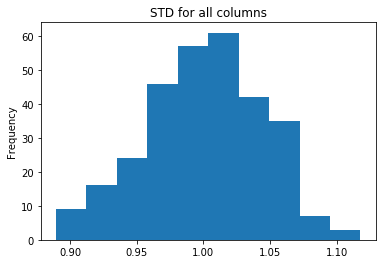

In [40]:
X_train.std().plot('hist')
plt.title('STD for all columns');

Text(0.5, 1.0, 'Means for all columns')

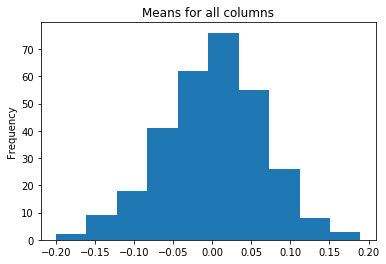

In [39]:
X_train.mean().plot('hist')

plt.title("Means for all columns");

In [41]:
y_train.value_counts()

1.0    160
0.0     90
Name: target, dtype: int64

In [51]:
corrs = train.corr().abs().unstack().sort_values(ascending=True).reset_index()
corrs = corrs[corrs['level_0'] != corrs['level_1']]
corrs.tail(10)

,level_0,level_1,0
90892,22,28,0.246062
90893,28,22,0.246062
90894,193,101,0.252825
90895,101,193,0.252825
90896,75,32,0.259315
90897,32,75,0.259315
90898,target,65,0.293846
90899,65,target,0.293846
90900,33,target,0.373608
90901,target,33,0.373608


In [55]:
# корреляции между признаками маленькие с самой большой в 0.374

In [101]:
n_folds = 20
SKfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
repeated_fold = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=20, random_state=42)

In [102]:
scaler=StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [107]:
#train models with strafitied KFold, oof and pred, template 

In [118]:
def train_model(X, 
                X_test, 
                y, 
                params, 
                folds=SKfold, 
                model_type='lgb', 
                plot_feature_importance=False, 
                averaging='usual', 
                model=None
                ):
    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        # print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X[train_index], X[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=2000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_tr.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_tr.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X_tr.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000,  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
            
            
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            y_pred = model.predict_proba(X_test)[:, 1]
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            y_pred = model_results.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))

        if averaging == 'usual':
            prediction += y_pred
        elif averaging == 'rank':
            prediction += pd.Series(y_pred).rank().values  
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_folds
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

In [74]:
# очевидно, что логрег тут должен справиться хорошо, посмотрим

In [108]:
LR = linear_model.LogisticRegression(solver='liblinear', max_iter=10000)
param_grid = {"class_weight" : ['balanced', None], 
              "penalty" : ['l1', "l2"],
              'C' : [0.001, 0.01, 0.08, 0.1, 0.15, 1.0, 10.0, 100.0]
              }
CV = GridSearchCV(LR, param_grid = param_grid, cv = n_folds, scoring= 'roc_auc')
CV.fit(X_train, y_train)
print ('Best score :{}'.format(CV.best_score_))
print ('Best parameters :{}'.format(CV.best_params_))

Best score :0.8169
Best parameters :{'C': 0.1, 'class_weight': None, 'penalty': 'l1'}


In [109]:
model = linear_model.LogisticRegression(max_iter=10000, 
                                        class_weight=CV.best_params_['class_weight'],
                                        penalty=CV.best_params_['penalty'], 
                                        C=CV.best_params_["C"]
                                        )

oof_lr, prediction_lr, scores = train_model(X_train_scaled, X_test_scaled, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7063, std: 0.1132.


In [76]:
# теперь взглянем на другие классификаторы

In [119]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
params = {'n_estimators' : [10, 50, 100, 1000],
           'max_depth' : [None, 2, 3, 5, 10], # not really needed 
           'max_features' : ['sqrt', 'log2']
          }
CV = GridSearchCV(RF, param_grid = params, cv = n_folds, n_jobs = -1, scoring = 'roc_auc')
CV.fit(X_train, y_train)
print ("Best score: {}".format(CV.best_score_))
print ("Best parameters: {}".format(CV.best_params_))

Best score: 0.7549
Best parameters: {'max_depth': 3, 'max_features': 'sqrt', 'n_estimators': 1000}


In [120]:
model_RF = RandomForestClassifier(**CV.best_params_)
oof_RF, prediction_RF, scores_RF = train_model(X_train_scaled, X_test_scaled, y_train, params = None, model_type = 'sklearn', model = RF)

CV mean score: 0.5750, std: 0.0913.


In [122]:
from sklearn.svm import SVC
svc = SVC(probability = True, gamma = 'scale')
params = {'C' : [0.001, 0.01, 0.1, 1, 10],
          'kernel' : ['linear','poly', 'rbf']
         }
CV = GridSearchCV(svc, param_grid = params, cv = n_folds, scoring = 'roc_auc', n_jobs = -1)
CV.fit(X_train, y_train)
print ('Best score: {}'.format(CV.best_score_))
print ('Best parameters: {}'.format(CV.best_params_))

Best score: 0.7723000000000001
Best parameters: {'C': 0.1, 'kernel': 'linear'}


In [124]:
svc = SVC(probability = True, gamma = 'scale', **CV.best_params_)
oof_svc, prediction_svc, scores_svc = train_model(X_train_scaled, X_test_scaled, y_train, params = None, model_type = 'sklearn', model = svc)

CV mean score: 0.6750, std: 0.1399.


In [125]:
# SVC тоже справился хорошо, в любом случае позже сравним всех с логрегрессией

In [126]:
from sklearn.neighbors import KNeighborsClassifier
knc = KNeighborsClassifier()

params = {'n_neighbors': [2, 3, 5, 10, 20],
                  'weights': ['uniform', 'distance'],
                  'leaf_size': [5, 10, 30]
                 }

CV = GridSearchCV(knc, param_grid=params, cv=n_folds, scoring='roc_auc', n_jobs=-1)
CV.fit(X_train, y_train)
print('Best score: {}'.format(CV.best_score_))
print('Best parameters: {}'.format(CV.best_params_))
knc = KNeighborsClassifier(**CV.best_params_)
oof_knc, prediction_knc, scores_knc = train_model(X_train_scaled, X_test_scaled, y_train, params=None, model_type='sklearn', model=knc)

Best score: 0.6427999999999999
Best parameters: {'leaf_size': 5, 'n_neighbors': 10, 'weights': 'distance'}
CV mean score: 0.5981, std: 0.1391.


In [127]:
from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()

params = {'alpha': [0.0001, 1, 2, 10]
                 }

CV = GridSearchCV(bnb, param_grid=params, cv=n_folds, scoring='roc_auc', n_jobs=-1)
CV.fit(X_train, y_train)
print('Best score: {}'.format(CV.best_score_))
print('Best parameters: {}'.format(CV.best_params_))
bnb = BernoulliNB(**CV.best_params_)
oof_bnb, prediction_bnb, scores_bnb = train_model(X_train_scaled, X_test_scaled, y_train, params=None, model_type='sklearn', model=bnb)

Best score: 0.6477999999999999
Best parameters: {'alpha': 0.0001}
CV mean score: 0.5950, std: 0.1049.


In [133]:
sgd = linear_model.SGDClassifier(eta0=1, max_iter=1000, tol=0.0001)

params = {'loss': ['log', 'modified_huber'],
                  'penalty': ['l1', 'l2', 'elasticnet'],
                  'alpha': [0.001, 0.01, 0.05],
                  'l1_ratio': [0, 0.15, 0.5, 1.0],
                  'learning_rate': ['optimal', 'invscaling', 'adaptive']
                 }

CV = GridSearchCV(sgd, param_grid=params, cv=n_folds, scoring='roc_auc', n_jobs=-1)
CV.fit(X_train_scaled, y_train)
print('Best score: {}'.format(CV.best_score_))
print('Best parameters: {}'.format(CV.best_params_))
sgd = linear_model.SGDClassifier(eta0=1, tol=0.0001, **CV.best_params_)
oof_sgd, prediction_sgd, scores_sgd = train_model(X_train_scaled, X_test_scaled, y_train, params=None, model_type='sklearn', model=sgd)

Best score: 0.8341000000000001
Best parameters: {'alpha': 0.05, 'l1_ratio': 0, 'learning_rate': 'adaptive', 'loss': 'log', 'penalty': 'l1'}
CV mean score: 0.6750, std: 0.0855.


In [130]:
from sklearn.gaussian_process import GaussianProcessClassifier
gpc = GaussianProcessClassifier()
oof_gpc, prediction_gpc, scores_gpc = train_model(X_train_scaled, X_test_scaled, y_train, params=None, model_type='sklearn', model=gpc)

CV mean score: 0.5819, std: 0.1431.


In [131]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()

params = {'n_estimators': [10, 50, 100, 1000],
                  'max_depth': [None, 3, 5, 15]
                 }

CV = GridSearchCV(etc, param_grid=params, cv=n_folds, scoring='roc_auc', n_jobs=-1)
CV.fit(X_train_scaled, y_train)
print('Best score: {}'.format(CV.best_score_))
print('Best parameters: {}'.format(CV.best_params_))
etc = ExtraTreesClassifier(**CV.best_params_)
oof_etc, prediction_etc, scores_etc = train_model(X_train_scaled, X_test_scaled, y_train, params=None, model_type='sklearn', model=etc)

Best score: 0.7552000000000001
Best parameters: {'max_depth': 5, 'n_estimators': 1000}
CV mean score: 0.5000, std: 0.0000.


In [136]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()

params = {'n_estimators': [5, 10, 20, 50, 100],
                  'learning_rate': [0.001, 0.01, 0.1, 1.0, 10.0]
                 }

CV = GridSearchCV(abc, param_grid=params, cv=n_folds, scoring='roc_auc')
CV.fit(X_train_scaled, y_train)
print('Best score: {}'.format(CV.best_score_))
print('Best parameters: {}'.format(CV.best_params_))

Best score: 0.7109500000000001
Best parameters: {'learning_rate': 0.01, 'n_estimators': 100}


In [137]:
abc = AdaBoostClassifier(**CV.best_params_)
oof_abc, prediction_abc, scores_abc = train_model(X_train_scaled, X_test_scaled, y_train, params=None, model_type='sklearn', model=abc)

CV mean score: 0.5406, std: 0.0755.


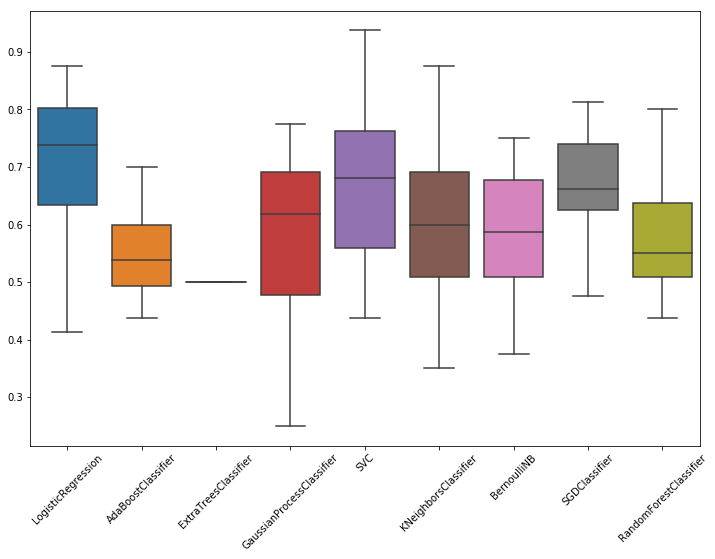

In [148]:
plt.figure(figsize=(12, 8));
scores_df = pd.DataFrame({'LogisticRegression': scores})
scores_df['AdaBoostClassifier'] = scores_abc
scores_df['ExtraTreesClassifier'] = scores_etc
scores_df['GaussianProcessClassifier'] = scores_gpc
scores_df['SVC'] = scores_svc
scores_df['KNeighborsClassifier'] = scores_knc
scores_df['BernoulliNB'] = scores_bnb
scores_df['SGDClassifier'] = scores_sgd
scores_df['RandomForestClassifier'] = scores_RF
sns.boxplot(data=scores_df);
plt.xticks(rotation=45);

In [149]:
# чтд LR и SVC выделяются. Блендим, смотрим гистограмму распределения oof предсказаний.

In [150]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']
X_test = test.drop(['id'], axis=1)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = linear_model.LogisticRegression(class_weight='balanced', penalty='l1', C=0.1, solver='liblinear')
oof_lr, prediction_lr, _ = train_model(X_train, X_test, y_train, params=None, model_type='sklearn', model=model)

CV mean score: 0.7112, std: 0.1198.


In [153]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = (prediction_lr + prediction_svc) / 2
submission.to_csv('submission.csv', index=False)

submission.head()

,id,target
0,250,0.555294
1,251,0.396965
2,252,0.572044
3,253,0.843185
4,254,0.472588


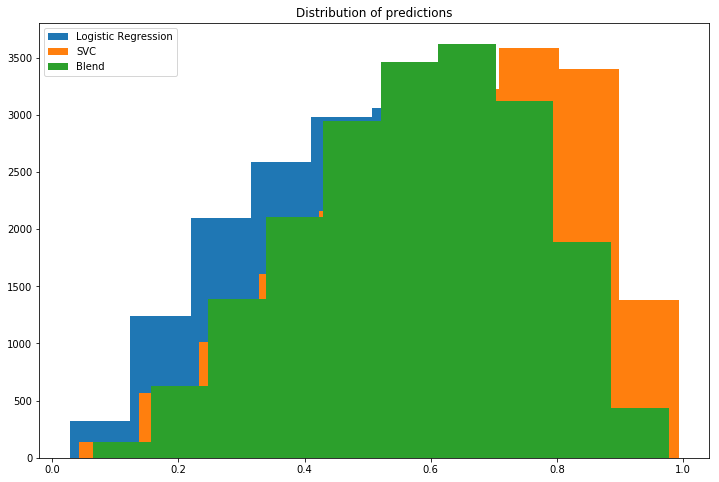

In [161]:
plt.figure(figsize = (12,8))
plt.hist (prediction_lr, label = 'Logistic Regression')
plt.hist (prediction_svc, label = 'SVC')
plt.hist ((prediction_lr+prediction_svc) / 2, label = 'Blend')
plt.title ('Distribution of predictions')
plt.legend();

In [164]:
submission['target'] = prediction_lr
submission.to_csv('submission.csv', index=False)

submission.head()

,id,target
0,250,0.669671
1,251,0.487245
2,252,0.515429
3,253,0.760070
4,254,0.445292


In [173]:
# просто logreg дает больший скор на LB. Пробуем lgbm, 
# далее варианты - distance-based признаки, полиномиальные признаки, теоретический анализ (не годится), 
# отбор признаков

In [139]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [143]:
from sklearn.model_selection import train_test_split
X_train_sp, X_test_sp, y_train_sp, y_test_sp = train_test_split(X_train_scaled, y_train, test_size=0.20, random_state=42, stratify=y_train)

In [144]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test_sp,y_test_sp)],
            'eval_names': ['valid'],
            #'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
            'categorical_feature': 'auto'}

In [134]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
params = {'num_leaves': sp_randint(6, 50), 
          'min_child_samples': sp_randint(100, 500), 
          'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
          'subsample': sp_uniform(loc=0.2, scale=0.8), 
          'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
          'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
          'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]
          }

n_HP_points_to_test = 100

import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

#n_estimators is set to a "large value". The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
clf = lgb.LGBMClassifier(max_depth = -1, random_state = 42, silent = True, metric = 'None', n_jobs = -1, n_estimators = 5000)
CV = RandomizedSearchCV(
    estimator=clf, param_distributions=params, 
    n_iter=n_HP_points_to_test,
    scoring='roc_auc',
    cv=n_folds,
    refit=True,
    random_state=42,
    verbose=True)
CV.fit(X_train_scaled, y_train)
print ("Best score: {}".format(CV.best_score_))
print ("Best parameters: {}".format(CV.best_params_))

Fitting 20 folds for each of 100 candidates, totalling 2000 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 2000 out of 2000 | elapsed:  4.5min finished


Best score: 0.7814
Best parameters: {'colsample_bytree': 0.523027197103915, 'min_child_samples': 100, 'min_child_weight': 0.01, 'num_leaves': 18, 'reg_alpha': 2, 'reg_lambda': 20, 'subsample': 0.9025765339833538}


In [166]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

In [167]:
X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)

X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [170]:
X_train_poly.shape

(250, 45451)

In [172]:
# The number of polynomial features is ~45k which is too much. 
# We need some way to select some of them. Let's try use correlations with target.

In [174]:
cor = pd.DataFrame(X_train_poly).corrwith(y_train)

In [175]:
sc = []
for i in range(10, 510, 5):
    top_corr_cols = list(cor.abs().sort_values().tail(i).reset_index()['index'].values)
    X_train_poly1 = X_train_poly[:, top_corr_cols]
    X_test_poly1 = X_test_poly[:, top_corr_cols]
    oof_lr_poly, prediction_lr_poly, scores = train_model(X_train_poly1, X_test_poly1, y_train, params=None, model_type='sklearn', model=model)
    sc.append(scores)

CV mean score: 0.8087, std: 0.1248.
CV mean score: 0.8231, std: 0.1030.
CV mean score: 0.8488, std: 0.0963.
CV mean score: 0.8250, std: 0.0744.
CV mean score: 0.8375, std: 0.0887.
CV mean score: 0.8294, std: 0.1057.
CV mean score: 0.8406, std: 0.0961.
CV mean score: 0.8500, std: 0.1188.
CV mean score: 0.8394, std: 0.1063.
CV mean score: 0.8231, std: 0.1115.
CV mean score: 0.8363, std: 0.0919.
CV mean score: 0.8438, std: 0.0977.
CV mean score: 0.8281, std: 0.1247.
CV mean score: 0.8250, std: 0.1274.
CV mean score: 0.8356, std: 0.1354.
CV mean score: 0.8456, std: 0.1149.
CV mean score: 0.8425, std: 0.1089.
CV mean score: 0.8488, std: 0.1049.
CV mean score: 0.8381, std: 0.0953.
CV mean score: 0.8113, std: 0.0929.
CV mean score: 0.8306, std: 0.0796.
CV mean score: 0.8306, std: 0.0771.
CV mean score: 0.8387, std: 0.0818.
CV mean score: 0.8262, std: 0.0810.
CV mean score: 0.8025, std: 0.0788.
CV mean score: 0.8012, std: 0.0874.
CV mean score: 0.8044, std: 0.0853.
CV mean score: 0.7975, std: 

In [176]:
data = [go.Scatter(
        x = list(range(10, 510, 5)),
        y = [np.round(np.mean(i), 4) for i in sc],
        name = 'CV scores'
    )]
layout = go.Layout(dict(title = "Top N poly features vs CV",
                  xaxis = dict(title = 'Top N features'),
                  yaxis = dict(title = 'CV score'),
                  ))
py.iplot(dict(data=data, layout=layout), filename='basic-line')

In [ ]:
# видно было и без графика, что мы overfit

In [196]:
train_test(train, test)
X_train['300'] = X_train.std(1)
X_test['300'] = X_test.std(1)
scaler = StandardScaler()

X_train[X_train.columns[:-1]] = scaler.fit_transform(X_train[X_train.columns[:-1]])
X_test[X_test.columns[:-1]] = scaler.transform(X_test[X_test.columns[:-1]])
model = linear_model.LogisticRegression(class_weight = 'balanced',
                                        penalty = 'l1',
                                        C = 0.1,
                                        solver = 'liblinear'
                                        )
oof_lr_1, prediction_lr_1_repeated, scores = train_model(X_train.values, X_test.values, y_train, params = None, model_type = "sklearn", model = model, folds = repeated_fold)

CV mean score: 0.7134, std: 0.1215.


In [184]:
submission = pd.read_csv('sample_submission.csv')
submission['target'] = prediction_lr_1_repeated
submission.to_csv('repeated_fold_stats.csv', index = False)

submission.head()

,id,target
0,250,13.431643
1,251,9.751118
2,252,10.359592
3,253,15.158499
4,254,8.883522


In [197]:
#distance features

In [208]:
X_train = train.drop(['id', 'target'], axis=1)
X_test = test.drop(['id'], axis=1)

NN = NearestNeighbors(n_neighbors = 5, n_jobs = -1)
NN.fit(X_train)

dists, _ = NN.kneighbors(X_train, n_neighbors = 5)
mean_distance = dists.mean(axis =1)
max_distance = dists.max(axis = 1)
min_distance = dists.min(axis = 1)

X_train['300'] = X_train.std(1)

X_train = np.hstack((X_train, mean_distance.reshape(-1, 1), max_distance.reshape(-1, 1), min_distance.reshape(-1, 1)))

test_dists, _ = NN.kneighbors(X_test, n_neighbors = 5)

test_mean_distance = test_dists.mean(axis =1)
test_max_distance = test_dists.max(axis = 1)
test_min_distance = test_dists.min(axis = 1)

X_test['300'] = X_test.std(1)
X_test = np.hstack((X_test, test_mean_distance.reshape(-1, 1), test_max_distance.reshape(-1, 1), test_min_distance.reshape(-1, 1)))

In [209]:
# train+test?

In [210]:
model = linear_model.LogisticRegression(class_weight = 'balanced',
                                        C = 0.1,
                                        penalty = 'l1',
                                        solver = 'liblinear'
                                        )
oof_lr_2, prediction_lr_2, scores = train_model(X_train, X_test, y_train, params = None, model_type = 'sklearn', model = model)

CV mean score: 0.7431, std: 0.1204.


In [ ]:
submission['target']